In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.preprocessing import minmax_scale

from numpy.random import default_rng
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True, precision=2)
plt.style.use('seaborn') # pretty matplotlib plots
sns.set(font_scale=2)

#  Function

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(len(ytrue_N)):
        if (ytrue_N[i] == yhat_N[i] == 1):
            TP += 1
        elif (ytrue_N[i] == yhat_N[i] == 0):
            TN += 1
        elif (ytrue_N[i] == 0 and yhat_N[i] == 1):
            FP += 1
        else:
            FN += 1
    return TP, TN, FP, FN

In [3]:
def div_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = list()
    TN = list()
    FP = list()
    FN = list()
    
    for i in range(len(ytrue_N)):
        if (ytrue_N[i] == yhat_N[i] == 1):
            TP.append(i)
        elif (ytrue_N[i] == yhat_N[i] == 0):
            TN.append(i)
        elif (ytrue_N[i] == 0 and yhat_N[i] == 1):
            FP.append(i)
        else:
            FN.append(i)
    return TP, TN, FP, FN

In [4]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [5]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [6]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Plotting functions

In [7]:
def plot_data(x, y):
    plot_x_min, plot_x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    plot_y_min, plot_y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # plot the basic data points
    class0_x = x[y==0]
    class1_x = x[y==1]
    plt.scatter(class0_x[:,0], class0_x[:,1], c='r', marker='x', label='Class 0')
    plt.scatter(class1_x[:,0], class1_x[:,1], c='b', marker='o', label='Class 1')
    
    plt.xlim(plot_x_min, plot_x_max)
    plt.ylim(plot_y_min, plot_y_max)
    plt.legend()
    plt.title("Basic data")

In [8]:
def plot_model_prediction(model, x, y):
    plot_x_min, plot_x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    plot_y_min, plot_y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # plot the separator
    model_intercept = model.intercept_[0]
    weight1, weight2 = model.coef_.T
    line_intercept = -model_intercept/weight2
    line_slope = -weight1/weight2
    line_x = np.array([plot_x_min, plot_x_max])
    line_y = line_slope * line_x + line_intercept
    plt.plot(line_x, line_y, 'm', lw=1, ls='--')
    
    # plot the decision data (two colors)
    xx, yy = np.meshgrid(np.arange(plot_x_min, plot_x_max, 0.01),
                         np.arange(plot_y_min, plot_y_max, 0.01))
    vx, vy = xx.flatten(), yy.flatten()
    vx, vy = vx.reshape((len(vx), 1)), vy.reshape((len(vy), 1))
    grid = np.hstack((vx, vy))
    
    positive_predictions = model.predict(grid)
    zz = positive_predictions.reshape(xx.shape)
    contour = plt.contourf(xx, yy, zz, 
                           cmap=matplotlib.colors.ListedColormap(('r','b')), alpha=0.25)

    # plot the basic data points
    class0_x = x[y==0]
    class1_x = x[y==1]
    plt.scatter(class0_x[:,0], class0_x[:,1], c='r', marker='x', label='Class 0')
    plt.scatter(class1_x[:,0], class1_x[:,1], c='b', marker='o', label='Class 1')
        
    plt.xlim(plot_x_min, plot_x_max)
    plt.ylim(plot_y_min, plot_y_max)
    plt.legend()
    plt.title("Classification regions")

In [9]:
def plot_model_contour(model, x, y):
    plot_x_min, plot_x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    plot_y_min, plot_y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # plot the separator
    model_intercept = model.intercept_[0]
    weight1, weight2 = model.coef_.T
    line_intercept = -model_intercept/weight2
    line_slope = -weight1/weight2
    line_x = np.array([plot_x_min, plot_x_max])
    line_y = line_slope * line_x + line_intercept
    plt.plot(line_x, line_y, 'm', lw=1, ls='--')
    
    # plot the probability contour (control smoothness with 'levels' parameter)
    xx, yy = np.meshgrid(np.arange(plot_x_min, plot_x_max, 0.1),
                         np.arange(plot_y_min, plot_y_max, 0.1))
    vx, vy = xx.flatten(), yy.flatten()
    vx, vy = vx.reshape((len(vx), 1)), vy.reshape((len(vy), 1))
    grid = np.hstack((vx, vy))
    
    positive_predictions = model.predict_proba(grid)[:, 1]
    zz = positive_predictions.reshape(xx.shape)
    contour = plt.contourf(xx, yy, zz, cmap='Greys', levels=10)
    plt.colorbar(contour)

    # plot the basic data points
    class0_x = x[y==0]
    class1_x = x[y==1]
    plt.scatter(class0_x[:,0], class0_x[:,1], c='r', marker='x', label='Class 0')
    plt.scatter(class1_x[:,0], class1_x[:,1], c='b', marker='o', label='Class 1')
    
    plt.xlim(plot_x_min, plot_x_max)
    plt.ylim(plot_y_min, plot_y_max)
    plt.legend()
    plt.title("Probability(x in class 1)")

#  Load the dataset.

In [10]:
# Load 3 feature version of x arrays
x_train = np.loadtxt('./data_sneaker_vs_sandal/x_train.csv', delimiter=',', skiprows=1)
x_test = np.loadtxt('./data_sneaker_vs_sandal/x_test.csv', delimiter=',', skiprows=1)

y_train = np.loadtxt('./data_sneaker_vs_sandal/y_train.csv', delimiter=',', skiprows=1)

#  Split training data for training & validation set.

In [11]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.4)


# // check number of sneakers
# arr = np.array(y_train)
# len(np.nonzero(y_train)[0])

train : 7200
validation : 4800


sneakers : 6000
sandals : 6000

In [12]:
len(x_train)

12000

## Basic Logistic Regression

#### C = 1

In [13]:
model_list = list()

tr_loss_list = list()
va_loss_list = list()

tr_acc_list = list()
va_acc_list = list()

In [83]:
C_grid = np.logspace(-9, 1, 30)/10

In [85]:
C_grid

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.02, 0.04, 0.09, 0.2 , 0.45, 1.  ])

In [15]:
model = LogisticRegression(solver='liblinear', C=1)
model.fit(x_tr, y_tr)

prob_tr = model.predict_proba(x_tr)
prob_va = model.predict_proba(x_va)

acc_tr = model.score(x_tr, y_tr)
acc_va = model.score(x_va, y_va)

tr_log_loss = log_loss(y_tr,prob_tr)
va_log_loss = log_loss(y_va,prob_va)

acc_tr = model.score(x_tr, y_tr)
acc_va = model.score(x_va, y_va)

In [16]:
print("Train accuracy: ", acc_tr)
print("Validation accuracy: ", acc_va)

print("Train Log loss: ", tr_log_loss)
print("Validation Log loss: ", va_log_loss)

Train accuracy:  0.9761111111111112
Validation accuracy:  0.958125
Train Log loss:  0.07706247025358903
Validation Log loss:  0.11280976986158602


#### C = 1 : Train on all train data 

In [17]:
model = LogisticRegression(solver='liblinear', C=1)
model.fit(x_train, y_train)

prob_train = model.predict_proba(x_train)

acc_train = model.score(x_train, y_train)

train_log_loss = log_loss(y_train,prob_train)

acc_train = model.score(x_train, y_train)

In [18]:
train_log_loss

0.07912759446931152

In [19]:
acc_train 

0.9735

In [20]:
yproba1_test = model.predict_proba(x_test)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

#### Test for all data - Train on all train data 

In [21]:
for C in C_grid:
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(x_tr, y_tr)
    model_list.append(model)
    
    prob_tr = model.predict_proba(x_tr)
    prob_va = model.predict_proba(x_va)

    acc_tr = model.score(x_tr, y_tr)
    acc_va = model.score(x_va, y_va)

    tr_log_loss = log_loss(y_tr,prob_tr)
    va_log_loss = log_loss(y_va,prob_va)
    
    tr_loss_list.append(tr_log_loss)
    va_loss_list.append(va_log_loss)
    
    tr_acc_list.append(acc_tr)
    va_acc_list.append(acc_va)


KeyboardInterrupt: 

## find the best model 

In [22]:
min_va_loss = min(va_loss_list)
min_va_loss_index = va_loss_list.index(min_va_loss)
best_C =  C_grid[min_va_loss_index]
best_acc = va_acc_list[min_va_loss_index]

In [23]:
print("Best C-value for LR with 2-feature data: %.6f" % best_C) 
print("Test set log-loss at best C-value: %.4f" % min_va_loss)
print("Test set accuracy rate at best C-value: %.4f" % best_acc)

Best C-value for LR with 2-feature data: 0.316228
Test set log-loss at best C-value: 0.1106
Test set accuracy rate at best C-value: 0.9596


In [24]:
best_model = model_list[min_va_loss_index]
# yprob_va = best_model.predict_proba(x_va)
# print(calc_confusion_matrix_for_threshold(y_va, yprob_va[:, 1], 0.5))

In [25]:
# x_test = np.loadtxt('data_sneaker_vs_sandal/x_test.csv') 
yproba1_test = best_model.predict_proba(x_test)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

## Feature Scaling

### A basic perceptron model: one test

A simple perceptron model will often do an OK job on this data.  Performance can vary quite a bit, however, depending upon the exact test/train split we get, which by default is randomized across runs.  Performance can also be hampered somewhat by the fact that the original data is not scaled, and displays different orders of magnitude.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

### Scaling data features

We can use the exact same test/train split, but scale all our features to the $[0,1]$ range, independently (i.e., each is scaled according to its own maximum/minimum values).  This tends to give significantly better performance, since coefficient-weights on large-magnitude features are less likely to exert undue influence in the solution process.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html

In [26]:
print("-----------------\nClassify with scaled data, 1 split\n-----------------")
X_scaled_tr = minmax_scale(x_tr)
X_scaled_va = minmax_scale(x_va)

best_model.fit(X_scaled_tr, y_tr)
pred_tr = best_model.predict(X_scaled_tr)
pred_va = best_model.predict(X_scaled_va)

acc_tr = accuracy_score(pred_tr, y_tr)
acc_va = accuracy_score(pred_va, y_va)
print("Train accuracy: ", acc_tr)
print("Test accuracy: ", acc_va)

-----------------
Classify with scaled data, 1 split
-----------------
Train accuracy:  0.9711111111111111
Test accuracy:  0.9595833333333333


In [27]:
print("-----------------\nClassify with scaled data, 1 split\n-----------------")
X_scaled_train = minmax_scale(x_train)

best_model.fit(X_scaled_train, y_train)
pred_train = best_model.predict(X_scaled_train)
acc_train = accuracy_score(pred_train, y_train)
print("Train accuracy: ", acc_train)


-----------------
Classify with scaled data, 1 split
-----------------
Train accuracy:  0.9701666666666666


In [28]:
X_scaled_test = minmax_scale(x_test)
yproba1_test = best_model.predict_proba(X_scaled_test)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

### Cross-validation testing

Rather than a single randomized test/train split, we can automate the process somewhat by using $k$-fold cross validation techniques.  Like most things, there are a number of ways of handling this; this is one that is pretty basic, using a `KFold` object to generate splits of our data automatically.  Here, we do this for our basic, non-scaled data, using 5 folds.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [29]:
print("-----------------\nClassify with base data, 5 folds\n-----------------")

k = 5
kfold = KFold(n_splits=k)
train_scores = []
test_scores = []

for train_idx, test_idx in kfold.split(x_tr):
    X_train, X_test = x_tr[train_idx,:], x_tr[test_idx,:]
    y_train, y_test = y_tr[train_idx], y_tr[test_idx]
    
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    print("Train accuracy: ", acc_train)
    print("Test accuracy: ", acc_test)
    
    train_scores.append(acc_train)
    test_scores.append(acc_test)
    
print("\nAverage train accuracy: ", np.average(acc_train))
print("Average test accuracy: ", np.average(acc_test))

-----------------
Classify with base data, 5 folds
-----------------


/Users/mac/opt/miniconda3/envs/ml135_env_sp21/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Train accuracy:  0.9977430555555555
Test accuracy:  0.9326388888888889


/Users/mac/opt/miniconda3/envs/ml135_env_sp21/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Train accuracy:  1.0
Test accuracy:  0.9159722222222222
Train accuracy:  1.0
Test accuracy:  0.9152777777777777


/Users/mac/opt/miniconda3/envs/ml135_env_sp21/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Train accuracy:  1.0
Test accuracy:  0.9166666666666666
Train accuracy:  1.0
Test accuracy:  0.9215277777777777

Average train accuracy:  1.0
Average test accuracy:  0.9215277777777777


### Combining data transformation and cross-validation

We can also do our $k$-fold validation of data after scaling each feature to $[0,1]$.  This gives us the best accuracy and most robust expected performance.

This code is almost identical to that above, but differs in how we access data.
    In the above, the `X.iloc[index,:]` notation is used, because the data is still in
    data-frame form from pandas.  Here, we index more directly as `X[index,:]`, because
    we have run `minmax_scale()` on it, which converts it from pandas frame to more basic
    array-based structure.
    
**NB**: the `KFold.split()` function can handle data in either pandas data-frame or 
    basic array-based format, and several more.  In general, most of sklearn is pretty good at handling all
    manner of basic linear data.  See the entry for 'array-like' at:
    
    https://scikit-learn.org/stable/glossary.html

In [30]:
print("-----------------\nClassify with scaled data, 5 folds\n-----------------")

""" 
"""

X_scaled = minmax_scale(x_train)
train_scores = []
test_scores = []

for train_idx, test_idx in kfold.split(X_scaled):
    X_train, X_test = X_scaled[train_idx,:], X_scaled[test_idx,:]
    Y_train, Y_test = y_train[train_idx], y_train[test_idx]
    
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    acc_train = accuracy_score(pred_train, Y_train)
    acc_test = accuracy_score(pred_test, Y_test)
    print("Train accuracy: ", acc_train)
    print("Test accuracy: ", acc_test)
    
    train_scores.append(acc_train)
    test_scores.append(acc_test)
    
print("\nAverage train accuracy: ", np.average(acc_train))
print("Average test accuracy: ", np.average(acc_test))

-----------------
Classify with scaled data, 5 folds
-----------------


IndexError: index 5760 is out of bounds for axis 0 with size 5760

## What does the data look like 

In [31]:
# sandals : x_train[sandal_i]
sandals_i = y_train.nonzero()
sneakers_i = np.setdiff1d( np.arange(0, 12000), sandals_i) 

# 6000 sandals
# 6000 sneakers

In [56]:
rng = default_rng()

x_sneakers = x_train[sneakers_i]
x_sandals = x_train[sandals_i]

sample_sandals = rng.choice(x_train[sandals_i], 20)
sample_sneakers = rng.choice(x_train[sneakers_i], 20)

-----------------------


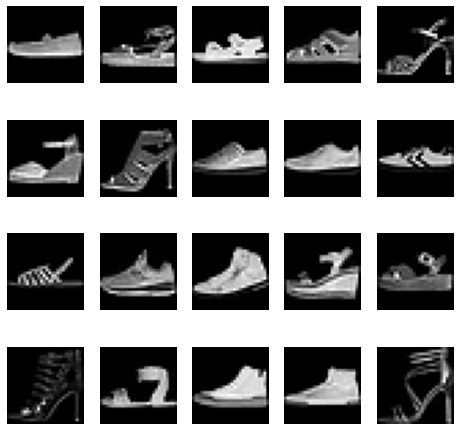

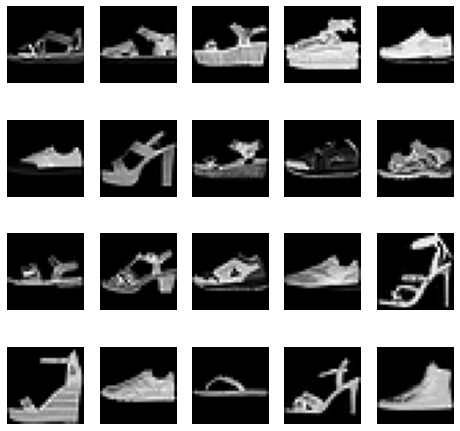

In [60]:
fig_sneakers = plt.figure(figsize=(8, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(np.reshape(sample_sandals[i], (28,28)), cmap=plt.cm.gray, vmin=0.0, vmax=1.0)

print('-----------------------')
fig_scandals = plt.figure(figsize=(8, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(np.reshape(sample_sneakers[i], (28,28)), cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
    
plt.show()

# histogram 

(array([8.44, 2.02, 1.25, 0.68, 0.48, 0.77, 0.9 , 0.86, 1.12, 0.7 ]),
 array([0.  , 0.06, 0.12, 0.17, 0.23, 0.29, 0.35, 0.41, 0.46, 0.52, 0.58]),
 <BarContainer object of 10 artists>)

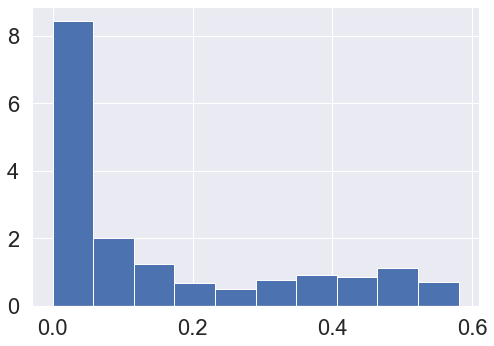

In [62]:
aver_sandals = np.mean(x_sandals,axis=0)
plt.hist(aver_sandals, density=True) 

In [47]:
aver_sandals.shape

(784,)

In [58]:
x_sneakers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(array([8.26, 2.18, 1.18, 0.65, 0.59, 0.68, 0.92, 1.09, 0.92, 0.63]),
 array([0.  , 0.06, 0.12, 0.18, 0.23, 0.29, 0.35, 0.41, 0.47, 0.53, 0.58]),
 <BarContainer object of 10 artists>)

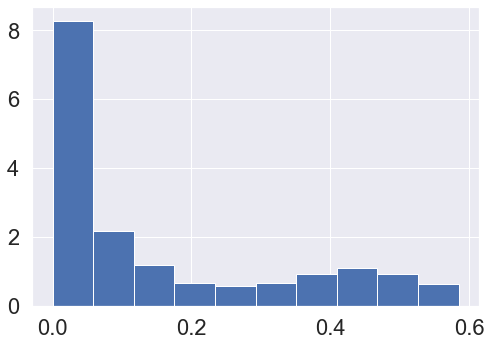

In [64]:
aver_sneakers = np.mean(x_sneakers,axis=0)
plt.hist(aver_sneakers, density=True) 

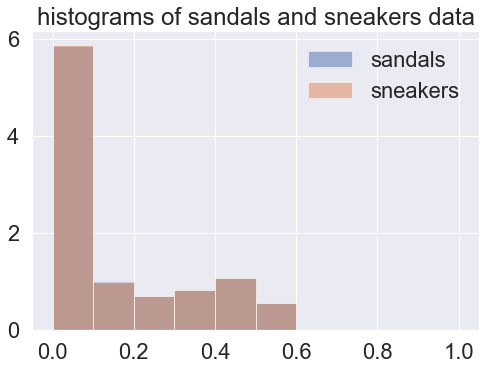

In [65]:
plt.title("histograms of sandals and sneakers data")
plt.hist(aver_sandals, bins = 10, range=(0,1), alpha=0.5, density=True, label='sandals')
plt.hist(aver_sneakers,  bins = 10, range=(0,1), alpha=0.5, density=True, label='sneakers')
plt.legend(loc='upper right')
plt.show()

In [49]:
x_train_ft_hist = []
x_test_ft_hist = []

for i in range(len(x_train)):
    his, _ = np.histogram(x_train[i],  bins = 5, range=(0,0.5), density=True)
    ft_hist = np.append(x_train[i], np.array(his))
    x_train_ft_hist.append(ft_hist)

for i in range(len(x_test)):  
    his, _ = np.histogram(x_test[i],  bins = 5, range=(0,0.5), density=True)
    ft_hist_test = np.append(x_test[i], np.array(his))
    x_test_ft_hist.append(ft_hist_test)

In [50]:
model = LogisticRegression(solver='liblinear', C=1)
model.fit(x_train_ft_hist, y_train)

prob_train = model.predict_proba(x_train_ft_hist)
acc_train = model.score(x_train_ft_hist, y_train)
train_log_loss = log_loss(y_train,prob_train)

ValueError: Found input variables with inconsistent numbers of samples: [12000, 5760]

In [ ]:
train_log_loss

In [ ]:
yproba1_test = model.predict_proba(x_test_ft_hist)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

##  Overall numbers of white or black pixels

In [ ]:
train_N, train_M = x_train.shape
test_N, test_M = x_test.shape

'''
    Adding pixel intensity as a new feature: 
    ------
        nBlack : pixel intensity is 0
        ✓ nWhite : pixel intensity is 1
        nDark  : pixel intensity less than 0.5
        ✓ nBright: pixel intensity greater or equal to 0.5    
'''

# count nBlack, nWhite, nDark, nBright
#   Xtrain features 
x_train_nWhite  = np.sum(x_train == 1, axis=1)
x_train_nBright = np.sum(x_train >= 0.5, axis=1)

#  Xtest features
x_test_nWhite  = np.sum(x_test == 1, axis=1)
x_test_nBright = np.sum(x_test >= 0.5, axis=1)

# amplify valid pixels (nWhite and nBright) 
#   Xtrain features 
x_train_bnw_features = np.concatenate((x_train_nWhite, x_train_nBright)).reshape(train_N,-1)
x_train_ft_bnw = np.append(x_train, x_train_bnw_features, axis=1)

#   Xtest features 
x_test_bnw_features = np.concatenate((x_test_nWhite, x_test_nBright)).reshape(test_N,-1)
x_test_ft_bnw = np.append(x_test, x_test_bnw_features, axis=1)

In [ ]:
# train model
model = LogisticRegression(solver='liblinear')
model.fit(x_train_bnw_features, y_train)


# calculate model score and log loss
prob_train = model.predict_proba(x_train_ft_bnw)
acc_train = model.score(x_train_ft_bnw, y_train)
train_log_loss = log_loss(y_train, prob_train)

In [ ]:
# predict the result
yproba1_test = model.predict_proba(x_test_ft_bnw)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

# histogram 

In [48]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.4)

ValueError: Found input variables with inconsistent numbers of samples: [12000, 5760]

In [ ]:
x_train_ft_hist = []
x_test_ft_hist = []

for i in range(len(x_train)):
    his, _ = np.histogram(x_train[i],  bins = 10, range=(0,1), density=True)
    ft_hist = np.append(x_train[i], np.array(his))
    x_train_ft_hist.append(ft_hist)
    

for i in range(len(x_test)):  
    his, _ = np.histogram(x_test[i],  bins = 10, range=(0,1), density=True)
    ft_hist_test = np.append(x_test[i], np.array(his))
    x_test_ft_hist.append(ft_hist_test)

In [ ]:
x_train_ft_hist

In [ ]:
model.fit(x_tr_ft_hist, y_tr)

prob_tr = model.predict_proba(x_tr_ft_hist)
acc_tr = model.score(x_tr_ft_hist, y_tr)
train_log_loss = log_loss(y_tr,prob_tr)

In [ ]:
yproba1_test = model.predict_proba(x_test_ft_hist)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

In [ ]:
print("-----------------\nClassify with base data, 5 folds\n-----------------")

k = 5
kfold = KFold(n_splits=k)
train_scores = []
test_scores = []

for train_idx, test_idx in kfold.split(x_train_ft_hist):
    X_train, X_test = x_train_ft_hist[train_idx,:], x_train_ft_hist[test_idx,:]
    Y_train, Y_test = y_train[train_idx], y_train[test_idx]
    
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    acc_train = accuracy_score(pred_train, Y_train)
    acc_test = accuracy_score(pred_test, Y_test)
    print("Train accuracy: ", acc_train)
    print("Test accuracy: ", acc_test)
    
    train_scores.append(acc_train)
    test_scores.append(acc_test)
    
print("\nAverage train accuracy: ", np.average(acc_train))
print("Average test accuracy: ", np.average(acc_test))

In [ ]:
aver = np.mean(x_train,axis=0)

plt.figure(figsize=(8, 8),frameon = True)
for index in range(len(aver)):
    plt.imshow(np.reshape(aver, (28,28)), cmap=plt.cm.RdYlBu,vmin=-0.5, vmax=0.5)
    
plt.title('shjakdhsaklds', loc='center')

plt.show()

In [ ]:
plt.imshow(best_model.coef_[0].reshape(28,28), cmap=plt.cm.RdYlBu ,vmin=-0.5, vmax=0.5)
plt.title('RdYlBu map of the coefficients', loc='center')
plt.show()

# Flip the data 


In [95]:
x_train_flip = np.flip(x_train, axis = 1)
x_train_ft_flip = np.append(x_train, x_train_flip,axis=0)

In [99]:
y_train_ft_flip = np.append(y_train, y_train,axis=0)

In [101]:
model = LogisticRegression(solver='liblinear')
model.fit(x_train_ft_flip, y_train_ft_flip)

prob_train = model.predict_proba(x_train_ft_flip)
acc_train = model.score(x_train_ft_flip, y_train_ft_flip)
train_log_loss = log_loss(y_train_ft_flip,prob_train)

In [104]:
yproba1_test = model.predict_proba(x_test)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

## try different C

In [107]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train_ft_flip, y_train_ft_flip, test_size=0.4)

In [108]:
C_grid = np.logspace(-9, 6, 31)

In [109]:
for C in C_grid:
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(x_tr, y_tr)
    model_list.append(model)
    
    prob_tr = model.predict_proba(x_tr)
    prob_va = model.predict_proba(x_va)

    acc_tr = model.score(x_tr, y_tr)
    acc_va = model.score(x_va, y_va)

    tr_log_loss = log_loss(y_tr,prob_tr)
    va_log_loss = log_loss(y_va,prob_va)
    
    tr_loss_list.append(tr_log_loss)
    va_loss_list.append(va_log_loss)
    
    tr_acc_list.append(acc_tr)
    va_acc_list.append(acc_va)

In [110]:
min_va_loss = min(va_loss_list)
min_va_loss_index = va_loss_list.index(min_va_loss)
best_C =  C_grid[min_va_loss_index]
best_acc = va_acc_list[min_va_loss_index]

In [111]:
print("Best C-value for LR with 2-feature data: %.6f" % best_C) 
print("Test set log-loss at best C-value: %.4f" % min_va_loss)
print("Test set accuracy rate at best C-value: %.4f" % best_acc)

Best C-value for LR with 2-feature data: 0.316228
Test set log-loss at best C-value: 0.1207
Test set accuracy rate at best C-value: 0.9556


In [112]:
best_model = model_list[min_va_loss_index]

In [113]:
yproba1_test = model.predict_proba(x_test)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)